In [1]:
import sys

In [2]:
sys.path.insert(0, '/home/nsiemer/home-win/pyiron_git/pyiron_contrib')

In [3]:
from pyiron_atomistics import Project
from pyiron_contrib import RDM
import numpy as np 
import matplotlib.pyplot as plt

%config inlinebackend.figure_format='retina'

/home/nsiemer/home-win/pyiron_git/pyiron_contrib/pyiron_contrib/RDM/__init__.py:7: UserWarning: pyiron module not found, importing Project from pyiron_base
  warnings.warn("pyiron module not found, importing Project from pyiron_base")


In [4]:
pr = Project('Chemical_potential')

co_pr = pr.storage_interface.create.coscine()
a_res = co_pr['SFB1394']['C05']['S7_GB_DPD_data']
pr.storage_interface.attach('S7_GB_DPD_data', a_res)

Coscine token:  ········


TypeError: Project.subproject() got an unexpected keyword argument 'display_name'

In [22]:
# class to plot DPDs
class construct_DPD():
    
    def __init__(self, mu_x, energies, labels, colors):
        self.mu_x = mu_x
        self.energies = energies
        self.labels = labels
        self.colors = colors
        self.indices = []
        self.all_indices = []

    def ret_mu_pos(self, x, y): # function to return intersection point of 2 formation energy lines
        '''
        Returns the index of chemical potential where the 2 formation energies intersect. In case there is no intersection, returns the index of the highest chemical potential
        '''
        for i, s in enumerate(y):
            if np.abs(s-x[i])<1e-4:
                # print(i)
                ind = i
                break
            else:
                ind = len(x)
        return ind
    
    def get_indices(self):
        '''
        Returns lists containing indices of energies stable in DPD, indices of intersections and list containing indices of energies not stable in DPD.
        '''    
        all_inds, order, ordered_inds = [], [], [0]

        for i in range(len(self.energies)):
            inds = []
            for j in range(len(self.energies)):
                if i != j:
                    inds.append(self.ret_mu_pos(self.energies[i], self.energies[j]))

            all_inds.append(inds)

        all_inds = np.array(all_inds)
        order.append(np.where(self.energies[:,0]==np.min(self.energies[:,0]))[0][0])
        ordered_inds.append(np.min(all_inds[order[-1]]))
        
        counter = 1
        while(ordered_inds[-1]<len(self.mu_x)):
            counter += 1
            inds = np.where(all_inds==ordered_inds[-1])[0]
            inds = inds[inds != order[-1]][0]
            order.append(inds)
            try:
                ordered_inds.append(np.sort(all_inds[order[-1]])[np.where(np.sort(all_inds[inds])==ordered_inds[-1])[0][0]+1])
            except:
                ordered_inds.append(len(self.mu_x))
                
        rejected_inds = [int(i) for i in list(set(order).symmetric_difference(set(np.linspace(0, len(all_inds)-1, len(all_inds)))))]
                
        return order, ordered_inds, rejected_inds
    
    def plot(self, xlim=[-1, 0], ylim=[-5,25], xlabel=r'$\Delta\mu_{\rm Ga}$ [eV]', ylabel=r'$E_{\rm f}$ [meV/$\rm \AA^2$]', alpha_fill=1, legend=True):
        '''
        Plots the DPD for the given chemical potential and formation energies. 
        Args:
            xlim: x-axis limits; default is [-1,0]
            ylim: y-axis limits; default is [-5,25]
            xlabel: x-axis Label; default is "r'$\Delta\mu_{\rm Ga}$ [eV]'"
            ylabel: y-axis Label; default is "r'$E_{\rm f}$ [meV/$\rm \AA^2$]'"
            alpha_fill: alpha parameter to control transparency in shaded regions; default is 1.0
        '''
        order, ordered_inds, rejected_inds = self.get_indices()
        
        colors_list = np.concatenate([[self.colors[order[i]] for i in range(len(order))], [self.colors[rejected_inds[i]] for i in range(len(rejected_inds))]])
        
        plt.figure(figsize=(8,5))
        plt.xlim(xlim[0], xlim[-1])
        plt.ylim(ylim[0], ylim[1])
        plt.xlabel(xlabel, fontsize=18)
        plt.ylabel(ylabel, fontsize=18, labelpad=-5)
        plt.tick_params(axis='both', direction='in', top=True, right=True, length=10, pad=8, labelsize=17)
        
        for i in range(len(order)):
            plt.plot(self.mu_x[:ordered_inds[i]], 1000*self.energies[order[i]][:ordered_inds[i]], c=colors_list[i], alpha=0.5, ls='--', lw=2)
            plt.plot(self.mu_x[ordered_inds[i+1]:], 1000*self.energies[order[i]][ordered_inds[i+1]:], c=colors_list[i], alpha=0.3, ls='--', lw=2)
            plt.plot(self.mu_x[ordered_inds[i]:ordered_inds[i+1]], 1000*self.energies[order[i]][ordered_inds[i]:ordered_inds[i+1]], c=colors_list[i], lw=2)

            plt.fill_between(self.mu_x[ordered_inds[i]:ordered_inds[i+1]], 1000*self.energies[order[i]][ordered_inds[i]:ordered_inds[i+1]], 
                             y2=1000*np.min(self.energies), color=colors_list[i], label=self.labels[order[i]], alpha=alpha_fill)

        for i in range(len(rejected_inds)):
            plt.plot(self.mu_x, 1000*self.energies[rejected_inds[i]], c=colors_list[len(order)+i], ls='--', lw=2, label=self.labels[rejected_inds[i]])
                    
        plt.tight_layout()
        if legend:
            plt.legend(fontsize=13)

In [4]:
# chemical potentials of Mg and Ga from respective bulks

job = a_res.load_job(name='Mg_bulk.h5', project=pr)
mu_Mg = job.output.energy_tot[-1]/len(job.structure)

job = a_res.load_job(name='Ga_bulk.h5', project=pr)
mu_Ga = job.output.energy_tot[-1]/len(job.structure)

Mg_bulk.h5:   0%|          | 0.00/9.69M [00:00<?, ?B/s]

Ga_bulk.h5:   0%|          | 0.00/11.2M [00:00<?, ?B/s]

In [18]:
mu_Mg, mu_Ga

(-1.5065073075, -2.9067873625)

In [5]:
# energies and structure of the two Sigma 7 GB types

name = 'sig7b_type_a_eps_final_160'
job = a_res.load_job(name=name+'.h5', project=pr)
en_0Ga = job.output.energy_tot[-1]
structure = job.get_structure()

name = 'sig7b_type_t_eps_final_160'
job = a_res.load_job(name=name+'.h5', project=pr)
en_0Ga_t = job.output.energy_tot[-1]
structure_t = job.get_structure()

sig7b_type_a_eps_final_160.h5:   0%|          | 0.00/115M [00:00<?, ?B/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



sig7b_type_t_eps_final_160.h5:   0%|          | 0.00/121M [00:00<?, ?B/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [6]:
# atom IDs and labels for the selected sites at the GB

s_atoms_2 = [153,   151,  152, 156, 157,  1,   0,   2,   154,   155,   146,   145,   143]
sites_2 =   ['a1', 'a2', 'a3', 'b+', 'c+', 'd+', 'e+', 'f+', 'b-', 'c-', 'd-', 'e-', 'f-']

In [7]:
# reading data from pyiron tables for Sigma 7 GB containing upto 6 Ga atoms
all_labels, all_energies, min_inds = [], [], []
for i in range(1,7):
    name = 'Ga{}Mg{}'.format(i, 158-i)
    tab = a_res.load_job(project=pr, name=name+'.h5')
    df = tab.get_dataframe()
    df = df[df['GB Type'] == 'A']
    labels = np.unique(df['GB Site Labels'].tolist())
    energies, labels_list = [], []
    for j in range(len(labels)):
        energies.append(np.min(df[df['GB Site Labels'] == labels[j]]['Energy'].tolist()))
        labels_list.append(str(labels[j]).replace('p','').replace('m','\''))
    all_labels.append(labels_list)
    all_energies.append(energies)
    min_inds.append(np.argmin(energies))

Ga1Mg157.h5:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

Ga2Mg156.h5:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

Ga3Mg155.h5:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Ga4Mg154.h5:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

Ga5Mg153.h5:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

Ga6Mg152.h5:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

In [8]:
# Grain boundary Area (same for A and the T type)

GB_area = 2*structure.cell[2][2]*structure.cell[1][1]

In [9]:
# pure Mg GB formation energies

Ef_0Ga_GB = (en_0Ga - (len(structure)*mu_Mg))/GB_area # formation energy of pure A type GB
Ef_0Ga_GB_T = (en_0Ga_t - (len(structure_t)*mu_Mg))/GB_area # formation energy of pure T type GB

In [10]:
start_mu = mu_Ga - 1
end_mu = mu_Ga + 0.5 
grid = 3000 # number of points between start_mu and end_mu

def formation_energies(n, t, e_sup):
    Ef_initial = 2*e_sup - en_0Ga - (t-(2*n))*mu_Mg - (2*n)*(start_mu)
    Ef_final = 2*e_sup - en_0Ga - (t-2*n)*mu_Mg - 2*n*(end_mu)
    return np.linspace(Ef_initial, Ef_final, grid)/GB_area

In [11]:
# formation energies and labels for all Ga arrangements

formation_energies_list, labels_list = [], []
for i in range(1,7):
    formation_energies_list.append(formation_energies(i, len(structure), all_energies[i-1][min_inds[i-1]]))
    labels_list.append(all_labels[i-1][min_inds[i-1]])

In [12]:
# calculate chemical potential of Ga in the Mg5Ga2 intermetallic phase

name = 'Mg5Ga2_relaxed'
job = a_res.load_job(name=name+'.h5',project=pr)
E_Mg5Ga_relaxed = job.output.energy_tot[-1]
relaxed_struct = job.get_structure()
N_Mg = len(relaxed_struct.select_index(el='Mg'))
N_Ga = len(relaxed_struct.select_index(el='Ga'))

mu_Ga_Mg5Ga_relaxed = (E_Mg5Ga_relaxed - (N_Mg*mu_Mg))/N_Ga

name = 'Mg5Ga2_constrained'
job = a_res.load_job(name=name+'.h5',project=pr)
E_Mg5Ga_constd = job.output.energy_tot[-1]
constrained_struct = job.get_structure()
N_Mg = len(constrained_struct.select_index(el='Mg'))
N_Ga = len(constrained_struct.select_index(el='Ga'))

mu_Ga_Mg5Ga_constd = (E_Mg5Ga_constd - (N_Mg*mu_Mg))/N_Ga
mu_Ga_Mg5Ga_relaxed, mu_Ga_Mg5Ga_constd

Mg5Ga_relax.h5:   0%|          | 0.00/19.1M [00:00<?, ?B/s]

Mg5Ga_constrained.h5:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

(-3.35680607125, -2.7504468925)

In [13]:
# selecting colors for the DPD

import matplotlib.colors as mcolors
import matplotlib.cm as cm

num = 20
mus = np.linspace(0, num, num+1, dtype=int)

colorparams = mus

colormap = cm.summer

normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

colors = []
num = 9
lim = 3
for i in range(lim):
    colors.append(colormap(normalize(mus[num+i*3])))
colors.reverse()


num = 20
mus = np.linspace(0, num, num+1, dtype=int)
colorparams = mus

colormap = cm.ocean

normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

colors.append(colormap(normalize(mus[int(len(mus)/1.34)])))

for i in range(lim):
    colors.append(colormap(normalize(mus[(12-i*3)%len(mus)])))
# colors.reverse()
    
text_col = 'k'

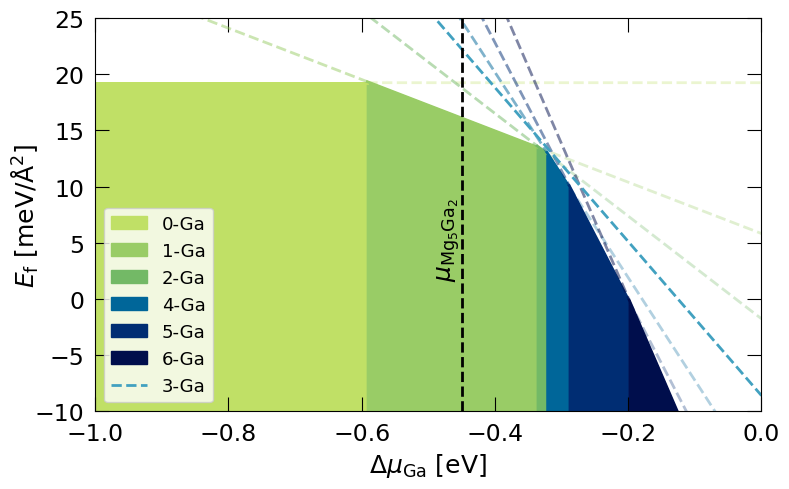

In [14]:
final_mu_Ga = np.linspace(mu_Ga-1, end_mu, grid) # chemical potentials for the defined range

# input chemical potential: 'mu_x', formation energies: ' energies', colors: 'colors' and labels corresponsding to energies: 'labels'
DPD = construct_DPD(mu_x=final_mu_Ga-mu_Ga, energies=np.concatenate([[np.array([Ef_0Ga_GB_T]*len(formation_energies_list[0]))], np.array(formation_energies_list)]), colors=colors, 
               labels=['0-Ga', '1-Ga', '2-Ga', '3-Ga', '4-Ga', '5-Ga', '6-Ga'])
# plotting the DPD using 'plot()'
DPD.plot(xlim=[-1,0], ylim=[-10,25], alpha_fill=1, legend=True)

# plotting chemical potential of Ga in Mg5Ga2
plt.axvline(x=mu_Ga_Mg5Ga_relaxed-mu_Ga, ymax=2, ymin=0, color='k', ls='--', lw=2)
plt.text(s=r'$\mu_{\rm Mg_5Ga_2}$', x=-0.49, y=2.5, c='k', fontsize=18, rotation=90);

In [15]:
DPD.get_indices()

([0, 1, 2, 4, 5, 6], [0, 817, 1327, 1356, 1423, 1603, 3000], [3])

## Experimental DPD energies

In [16]:
def get_index(l, cond):
    for i in range(len(l)):
        if l[i] == cond:
            break
            
    if l[i] == cond:        
        return i
    else:
        print('Match not found')

In [17]:
ind_2 = get_index(all_labels[2], str("b_c\'_e\'"))

ind_6 = get_index(all_labels[-1], str('b_c_e_b\'_c\'_e\''))

In [18]:
Ef_3Ga_exp = formation_energies(3, len(structure), all_energies[2][ind_2])
Ef_6Ga_exp = formation_energies(6, len(structure), all_energies[-1][ind_6])

In [19]:
ind_1_b, ind_1_c, ind_1_e = get_index(all_labels[0], str("b")), get_index(all_labels[0], str("c")), get_index(all_labels[0], str("e"))

In [20]:
E_1Ga_b = formation_energies(1, len(structure), all_energies[0][ind_1_b])

## Experimental DPD

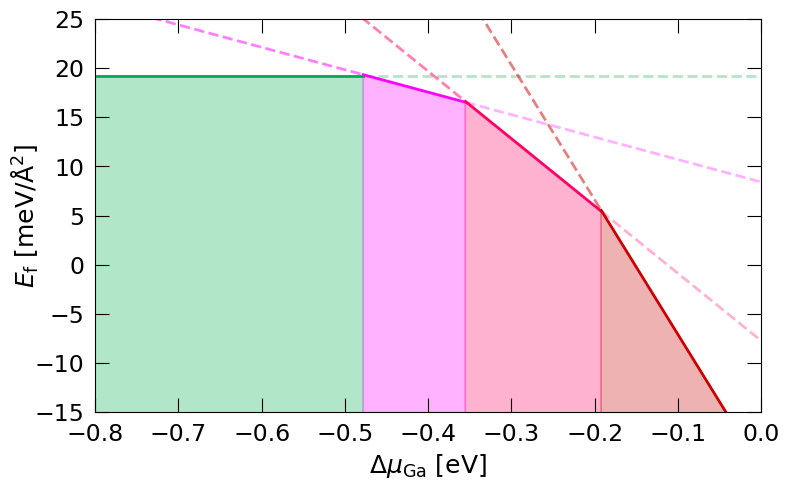

In [21]:
final_mu_Ga = np.linspace(mu_Ga-1, end_mu, grid)
exp_colors = ['#00ad4a', '#ff00ff', '#ff0066', '#cc0000']
text_col = 'white'

DPD = construct_DPD(mu_x=final_mu_Ga-mu_Ga, energies=np.array([[Ef_0Ga_GB_T]*len(E_1Ga_b), E_1Ga_b, Ef_3Ga_exp, Ef_6Ga_exp]), colors=exp_colors, 
               labels=['0-Ga', '1-Ga', '3-Ga', '6-Ga'])

DPD.plot(xlim=[-0.8,0], ylim=[-15,25], alpha_fill=0.3, legend=False)